file with exploratory calcualtions and plots, not directly related to the logical structure of POMDP_analysis.ipynb

In [ ]:
import numpy as np
import scipy as sp

# calculates the plug in entropy estimate for the elements of a given input sequence
def plugin_entropy(s):
    
    # calculate frequency of each unique sample value in order of appearance
    ucount = np.unique(s, return_counts = True)[1]
    # calculate entropy
    H = sp.stats.entropy(ucount, base = 2)

    return(H)

import matplotlib.pyplot as plt
## testing average entropy convergence  with sample length for fair coin flip
L = 200 # max length of measurements
N = 100 # number of repetitions to average over
H = np.zeros(L)
for l in range(1, L):
    for n in range(N):
        s = np.random.binomial(1, 0.5, l+1)
        H[l] += 1/N * plugin_entropy(s)

plt.plot(np.arange(1, L+1, 1), H)


# excess entropy
t_ent = 1 # true entropy of fair coin flip
ex_ent = t_ent + 0 # no entropy rate => excess entropy = true entropy
T = 1 - H
plt.plot(np.arange(1, L+1, 1), 1/np.arange(1, L+1, 1), color = "gray", ls = "--")
plt.plot(np.arange(1, L+1, 1), T)
plt.xlabel("L")
plt.ylabel("$\hat{H}_L(p)$")
print("total uncertainty:", np.sum(T))

In [82]:
import sympy as sym

# calculates the stationary distribution of a Markov Process using its transition matrix P
def MP_stat_dist(P): 

    # make symbolic if not already the case
    P = sym.Matrix(P)
    # take eigenvector with eigenvalue 1
    eigenvectors = P.T.eigenvects()
    eigenvector = [eig for eig in eigenvectors if eig[0]==1]
    stationary_dist = eigenvector[0][2][0]
    # normalize to probability vector
    stationary_dist = (stationary_dist/sum(stationary_dist)).T 

    return(sym.simplify(stationary_dist)) 

# calculate for used MPs
x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")

P_mdp = sym.Matrix([[1-x, x, 0],[a1, 0, 1-a1], [1, 0, 0]])
stat_mdp = MP_stat_dist(P_mdp)

P_mp1 = sym.Matrix([[1-x, x], [1/(2-a1), (1-a1)/(2-a1)]])
stat_mp1 = MP_stat_dist(P_mp1)

pa = stat_mdp[0]*a0 + stat_mdp[1]*a1 + stat_mdp[2]*a2
P_mp2 = sym.Matrix([[pa, 1-pa], [pa, 1-pa]])
stat_mp2 = MP_stat_dist(P_mp2)

In [19]:
import sympy as sym
import numpy as np

# calculates the entropy rate of a stationary Markov Process
def MP_entropy_rate(stat, P):

    # make inputs symbolic if not already
    stat_sym = sym.Matrix(stat)
    P_sym = sym.Matrix(P)
    # calculate entropy rate
    P_log = sym.matrix_multiply_elementwise(P_sym, P_sym.applyfunc(lambda x: sym.log(x, 2)))
    h = sym.simplify(-np.sum(P_log.T * stat_sym.T))

    return(h.evalf())

# test
P = np.array([[0.9, 0.1], [0.3, 0.7]])
stat = np.array([[0.75, 0.25]])
print(MP_entropy_rate(stat, P))

t = sym.Symbol("t")
stat = sym.Matrix([[t, 0.25]])
p_test = sym.Matrix([[0.9, 0.1], [0.3, 0.7]])
test = MP_entropy_rate(stat, p_test)
print(test.evalf(subs={t:0.75}))

0.572069419999634
0.572069419999634


In [110]:
import sympy as sym
import numpy as np
import itertools

# calculates block entropy of length block_length for MP with transition matrix P
def MP_block_entropy(P, block_length, init_prob):

    # get possible combinations of length = block_length
    P_size = np.shape(P)[0]
    blocks = list(itertools.product(range(P_size), repeat = block_length))

    # calculate probability for each possible block
    prob_blocks = list()
    for block in blocks:
        prob_block = 1
        for l in range(block_length):
            if l == 0:
                prob_block *= init_prob[block[l]]
            else:
                prob_block *= P[block[l-1], block[l]]
        prob_blocks.append(prob_block)

    # renormalize probabilities if impossible combinations were present (p=0)
    if 0 in prob_blocks: prob_blocks = list(filter(lambda p_b: p_b != 0, prob_blocks))
    prob_blocks = [p_b / np.sum(prob_blocks) for p_b in prob_blocks]

    # calculate entropy
    H = 0
    for p in prob_blocks:
        H -= p*sym.log(p, 2)
        
    return(H.evalf())

# test
p_init = np.eye(1, 2, k = 0)[0]
P = np.array([[0.9, 0.1], [0.3, 0.7]])
stat = np.array([0.75, 0.25])
print(MP_block_entropy(P, 10, p_init) - MP_block_entropy(P, 9, p_init))

P = np.array([[0.75, 0.25], [0.75, 0.25]])
print(MP_block_entropy(P, 10, p_init) - MP_block_entropy(P, 9, p_init))

0.570338175519465
0.811278124459055


In [35]:
# entropy rate vs block entropy convergence for mdp

h_mdp = sym.simplify(MP_entropy_rate(stat_mdp, P_mdp))
h_mdp = h_mdp.evalf(subs={x:0.25, a1:0.5})
print(h_mdp)

P_s = P_mdp.evalf(subs={x:0.25, a1:0.5})
P_s = np.array(P_s).astype(np.float64)
print(MP_block_entropy(P_s, 10, [1, 0, 0]) - MP_block_entropy(P_s, 9, [1, 0, 0]))

print(MP_block_entropy(P_mdp, 2, [1, 0, 0]))
print(MP_block_entropy(P_mp1, 2, [1, 0, 0]))

0.771838635970278
0.771846071374470
-1.44269504088896*p_X*log(p_X) - 1.44269504088896*(1.0 - p_X)*log(1 - p_X)
-1.44269504088896*p_X*log(p_X) - 1.44269504088896*(1.0 - p_X)*log(1 - p_X)


Matrix([[(\pi_{a0} - \pi_{a1}*\pi_{a2}*p_X + \pi_{a1}*p_X + \pi_{a2}*p_X)/(-\pi_{a1}*p_X + 2*p_X + 1), (-\pi_{a0} + \pi_{a1}*\pi_{a2}*p_X - 2*\pi_{a1}*p_X - \pi_{a2}*p_X + 2*p_X + 1)/(-\pi_{a1}*p_X + 2*p_X + 1)]])
1.44269504088896*(-\pi_{a1}*p_X*log(\pi_{a1}) + p_X*(\pi_{a1} - 1.0)*log(1 - \pi_{a1}) - p_X*log(p_X) + (p_X - 1.0)*log(1 - p_X))/(-\pi_{a1}*p_X + 2.0*p_X + 1.0) 
 1.44269504088896*(p_X*(\pi_{a1} - 1.0)*log((\pi_{a1} - 1)/(\pi_{a1} - 2)) - p_X*log(p_X) - p_X*log(-1/(\pi_{a1} - 2)) + (p_X - 1.0)*log(1 - p_X))/(-\pi_{a1}*p_X + 2.0*p_X + 1.0) 
 0.360673760222241*(-(\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1.0))*(\pi_{a0} - \pi_{a1}*\pi_{a2}*p_X + \pi_{a1}*p_X + \pi_{a2}*p_X)*log((\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1))/(-\pi_{a1}*p_X + 2*p_X + 1)) + (\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1.0))*(\pi_{a0} - \pi_{a1}*\pi_{a2}*p_X + 2.0*\pi_{a1}*p_X + \pi_{a2}*p_X - 2.0*p_X - 1.0)*log((\pi_{a0} + \pi_{a1}*p_X - \pi_{a2}*p_X*(\pi_{a1} - 1))/(-\pi

<lambdifygenerated-4>:2: RuntimeWarning: divide by zero encountered in log
  return -0.360673760222241*(-(-Dummy_197*p_X*(Dummy_198 - 1.0) + Dummy_198*p_X + Dummy_199)*(-Dummy_197*Dummy_198*p_X + Dummy_197*p_X + Dummy_198*p_X + Dummy_199)*log((-Dummy_197*p_X*(Dummy_198 - 1) + Dummy_198*p_X + Dummy_199)/(-Dummy_198*p_X + 2*p_X + 1)) + (-Dummy_197*p_X*(Dummy_198 - 1.0) + Dummy_198*p_X + Dummy_199)*(-Dummy_197*Dummy_198*p_X + Dummy_197*p_X + 2.0*Dummy_198*p_X + Dummy_199 - 2.0*p_X - 1.0)*log((-Dummy_197*p_X*(Dummy_198 - 1) + Dummy_198*p_X + Dummy_199)/(-Dummy_198*p_X + 2*p_X + 1)) - (-Dummy_197*Dummy_198*p_X + Dummy_197*p_X + Dummy_198*p_X + Dummy_199)*(Dummy_197*p_X*(Dummy_198 - 1.0) - 2.0*Dummy_198*p_X - Dummy_199 + 2.0*p_X + 1.0)*log((Dummy_197*p_X*(Dummy_198 - 1) - 2*Dummy_198*p_X - Dummy_199 + 2*p_X + 1)/(-Dummy_198*p_X + 2*p_X + 1)) + (Dummy_197*p_X*(Dummy_198 - 1.0) - 2.0*Dummy_198*p_X - Dummy_199 + 2.0*p_X + 1.0)*(-Dummy_197*Dummy_198*p_X + Dummy_197*p_X + 2.0*Dummy_198*p_X + Dumm

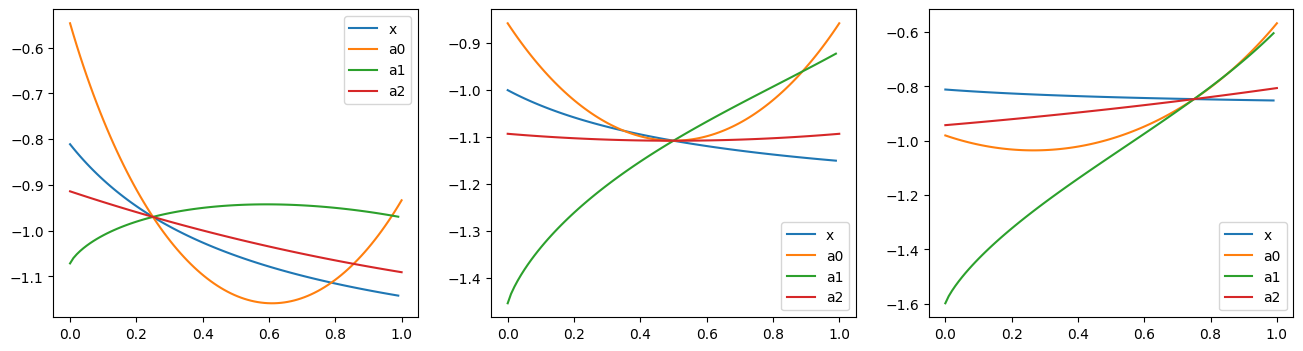

In [72]:
import matplotlib.pyplot as plt

# entropy rates
h_mdp = sym.simplify(MP_entropy_rate(stat_mdp, P_mdp))
h_mp1 = sym.simplify(MP_entropy_rate(stat_mp1, P_mp1))
h_mp2 = sym.simplify(MP_entropy_rate(stat_mp2, P_mp2))
print(stat_mp2)
print(h_mdp, "\n", h_mp1, "\n", h_mp2)


# lambdify for function plot
h_diff_l = sym.lambdify([x, a0, a1, a2], h_mdp-h_mp1-h_mp2)

plt.figure(figsize = (16, 4))
p = np.linspace(1e-23, 1-1e-23, 100)
plt.subplot(131)
c = 0.25
plt.plot(p, h_diff_l(p, c, c, c), label = "x")
plt.plot(p, h_diff_l(c, p, c, c), label = "a0")
plt.plot(p, h_diff_l(c, c, p, c), label = "a1")
plt.plot(p, h_diff_l(c, c, c, p), label = "a2")
plt.legend()

plt.subplot(132)
c = 0.5
plt.plot(p, h_diff_l(p, c, c, c), label = "x")
plt.plot(p, h_diff_l(c, p, c, c), label = "a0")
plt.plot(p, h_diff_l(c, c, p, c), label = "a1")
plt.plot(p, h_diff_l(c, c, c, p), label = "a2")
plt.legend()

plt.subplot(133)
c = 0.75
plt.plot(p, h_diff_l(p, c, c, c), label = "x")
plt.plot(p, h_diff_l(c, p, c, c), label = "a0")
plt.plot(p, h_diff_l(c, c, p, c), label = "a1")
plt.plot(p, h_diff_l(c, c, c, p), label = "a2")
plt.legend()

stat
0.857142857142857
disc
[0, 1.00000000000000, 2.00000000000000, 2.75000000000000, 3.62500000000000]
0.875000000000000
stat
1.37878349348618
disc
1.37878349348618
stat
0.964983928880495
disc
0.964821817440126
stat
1.00000000000000
disc
1.00000000000000


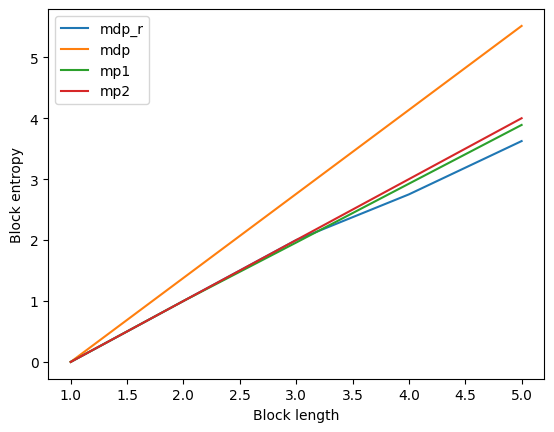

In [112]:
import numpy as np
import sympy as sym
import scipy as sp
import itertools
import matplotlib.pyplot as plt

vects = [stat_mdp, stat_mdp, stat_mp1, stat_mp2]
labels = ["mdp_r", "mdp", "mp1", "mp2"]
Ps = [P_mdp, sym.Matrix([stat_mdp, stat_mdp, stat_mdp]), P_mp1, P_mp2]

for n, vect in enumerate(vects):
    P_s = Ps[n]
    vars = [x, a0, a1, a2]
    vals = [0.5, 0.5, 0.5, 0.5]

    vect = vect.subs({vars[i]:vals[i] for i in range(len(vars))})
    P_s = P_s.subs({vars[i]:vals[i] for i in range(len(vars))})

    lengths = range(1, 6)

    print("stat")
    print(MP_entropy_rate(vect, P_s))
    #h_vect = sym.simplify(lp_static_mp_entropy_rate(vect, P_s))
    #print(h_vect.evalf(subs={vars[i]:vals[i] for i in range(len(vars))}))

    print("disc")
    block_ents = [MP_block_entropy(P_s, l, [1, 0, 0]) for l in lengths]
    if n == 0:
        print(block_ents)
    print(block_ents[-1] - block_ents[-2], )
    plt.plot(lengths, block_ents, label = labels[n])

plt.xlabel("Block length")
plt.ylabel("Block entropy")
plt.legend()
plt.show()


Issue with difference between real mdp and mdp in stationary

mp1 and mp2 also different, since are built with assumption of mp1 in stationary
=> actually invalid transitions in mdp are possible in mp1 and mp2

In [117]:
x = sym.Symbol("p_X")
a1 = sym.Symbol("\pi_{a1}")
stat_mdp_l = sym.lambdify([x, a1], stat_mdp, "numpy")
stat_t = stat_mdp_l(0.5, 0.5)
test = -stat_t[0,0]**2*np.log2(stat_t[0,0]**2) - stat_t[0,0]*stat_t[0,1]*np.log2(stat_t[0,0]*stat_t[0,1])
print(test)

stat_t = stat_mp1_l(0.5, 0.5)
test = -stat_t[0,0]**2*np.log2(stat_t[0,0]**2) - stat_t[0,0]*stat_t[0,1]*np.log2(stat_t[0,0]*stat_t[0,1])
print(test)

0.9541435971176531
1.024333176052489


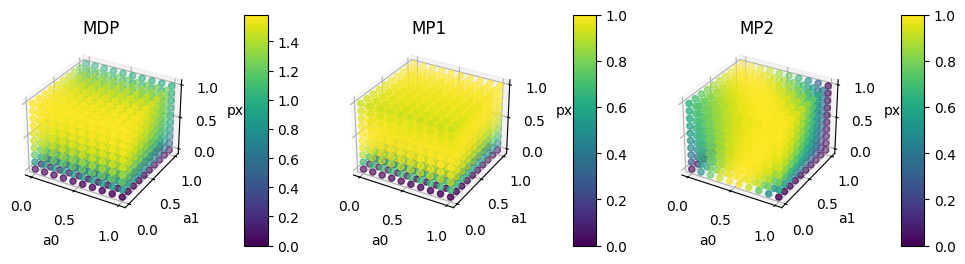

In [91]:
# visualize change in entropy of stationary distribution with change in action parameters
import numpy as np
import sympy as sym
import scipy as sp
import matplotlib.pyplot as plt

# lambdify stationary distributions for use in n dim plots
x = sym.Symbol("p_X")
a0 = sym.Symbol("\pi_{a0}")
a1 = sym.Symbol("\pi_{a1}")
a2 = sym.Symbol("\pi_{a2}")

stat_mdp_l = sym.lambdify([x, a1], stat_mdp, "numpy")
stat_mp1_l = sym.lambdify([x, a1], stat_mp1, "numpy")
stat_mp2_l = sym.lambdify([x, a0, a1, a2], stat_mp2, "numpy")

valrange = np.linspace(0, 1, 10)
px, a0, a1, a2 = np.meshgrid(valrange, valrange, valrange, 0.5)

fig = plt.figure(figsize = (12, 6))

entropy = sp.stats.entropy(stat_mdp_l(px, a1)[0], base = 2)
ax = fig.add_subplot(131, projection='3d')
img = ax.scatter(a0, a1, px, c = entropy, cmap=plt.colormaps['viridis'])
ax.set_xlabel("a0")
ax.set_ylabel("a1")
ax.set_zlabel("px")
ax.set_title("MDP")
fig.colorbar(img, shrink=0.5, aspect=10, pad = 0.2)

entropy = sp.stats.entropy(stat_mp1_l(px, a1)[0], base = 2)
ax = fig.add_subplot(132, projection='3d')
img = ax.scatter(a0, a1, px, c = entropy, cmap=plt.colormaps['viridis'])
ax.set_xlabel("a0")
ax.set_ylabel("a1")
ax.set_zlabel("px")
ax.set_title("MP1")
fig.colorbar(img, shrink=0.5, aspect=10, pad = 0.2)

entropy = sp.stats.entropy(stat_mp2_l(px, a0, a1, a2)[0], base = 2)
ax = fig.add_subplot(133, projection='3d')
img = ax.scatter(a0, a1, px, c = entropy, cmap=plt.colormaps['viridis'])
ax.set_xlabel("a0")
ax.set_ylabel("a1")
ax.set_zlabel("px")
ax.set_title("MP2")
fig.colorbar(img, shrink=0.5, aspect=10, pad = 0.2)

In [ ]:
# (currently not working) visualize for variation of each paramater (separately)
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

valrange = np.linspace(0, 1, 100)
const = 0.5*np.ones(100)

fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(valrange, lp_block_entropy(stat_mdp_l(valrange, const)[0], 1), "b-", label = "MDP")
plt.plot(valrange, lp_block_entropy(stat_mp1_l(valrange, const)[0], 1), "r-", label = "MP1")
plt.plot(valrange, lp_block_entropy(stat_mp2_l(valrange, const, const, const)[0], 1), "g-", label = "MP2, a0=c a2=c")
plt.plot(valrange, lp_block_entropy(stat_mp2_l(valrange, 0.5*const, const, const)[0], 1), "g--",label = "MP2, a0=0.5c a2=c")
plt.plot(valrange, lp_block_entropy(stat_mp2_l(valrange, const, const, 0.5*const)[0], 1), "g:", label = "MP2, a0=c a2=0.5c")
plt.xlabel("px")
plt.ylabel("Entropy")

plt.subplot(122)
plt.plot(valrange, lp_block_entropy(stat_mdp_l(const, valrange)[0], 1), "b-", label = "MDP")
plt.plot(valrange, lp_block_entropy(stat_mp1_l(const, valrange)[0], 1), "r-", label = "MP1")
plt.plot(valrange, lp_block_entropy(stat_mp2_l(const, const, valrange, const)[0], 1), "g-", label = "MP2, a0=c a2=c")
plt.plot(valrange, lp_block_entropy(stat_mp2_l(const, 0.5*const, valrange, const)[0], 1), "g--",label = "MP2, a0=0.5c a2=c")
plt.plot(valrange, lp_block_entropy(stat_mp2_l(const, const, valrange, 0.5*const)[0], 1), "g:", label = "MP2, a0=c a2=0.5c")
plt.xlabel("a1")
plt.ylabel("Entropy")

plt.legend()